### Imports

In [1]:
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask

import geopandas as gpd

import shapely

import pandas as pd
import json

import os
import matplotlib.pyplot as plt

### Load Index CSV

In [2]:
index = pd.read_csv('../data/arcticdem_index_intersection.csv')
index = index.iloc[:, 1:]

index = index[['name', 'raster', 'fileurl', 'minx', 'maxx', 'miny', 'maxy']]

In [3]:
index.head()

name      raster  \
0  SETSM_GE01_20120820_1050410003FF2E00_105041000...  2018-04-12   
1  SETSM_GE01_20120812_10504100007CE100_105041000...  2017-09-29   
2  SETSM_GE01_20120820_1050410003FF2E00_105041000...  2018-04-12   
3  SETSM_GE01_20120812_10504100007A7300_105041000...  2017-09-29   
4  SETSM_GE01_20120813_1050410000870B00_105041000...  2017-09-29   

                                             fileurl       minx       maxx  \
0  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD... -2029284.0 -2008648.0   
1  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD... -2087418.0 -2049076.0   
2  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD... -2016832.0 -2005532.0   
3  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD... -2086408.0 -2047890.0   
4  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD... -2087612.0 -2047606.0   

       miny      maxy  
0  634174.0  653348.0  
1  658334.0  683876.0  
2  631818.0  649366.0  
3  661454.0  686714.0  
4  659384.0  686590.0

### Filter for 2017

#### Change 'raster' column to datetime

In [4]:
index['raster'] = pd.to_datetime(index['raster'], format='%Y-%m-%d')

In [5]:
index_2017 = index.loc[(index['raster'] > '2016-12-31') & (index['raster'] < '2018-01-01')]
index_2017 = index_2017.reset_index(drop=True)
index_2017 = index_2017.set_index('name', drop=True)

In [6]:
index_2017.head()

raster  \
name                                                            
SETSM_GE01_20120812_10504100007CE100_1050410000... 2017-09-29   
SETSM_GE01_20120812_10504100007A7300_1050410000... 2017-09-29   
SETSM_GE01_20120813_1050410000870B00_1050410000... 2017-09-29   
SETSM_W1W1_20150924_10200100430C5200_1020010043... 2017-12-26   
SETSM_W1W1_20080409_1020010001144900_1020010002... 2017-12-26   

                                                                                              fileurl  \
name                                                                                                    
SETSM_GE01_20120812_10504100007CE100_1050410000...  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD...   
SETSM_GE01_20120812_10504100007A7300_1050410000...  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD...   
SETSM_GE01_20120813_1050410000870B00_1050410000...  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD...   
SETSM_W1W1_20150924_10200100430C5200_1020010043...  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD...   
SETSM_W1W1_20080409_1020010001144900_1020010002...  http://data.pgc.umn.edu/elev/dem/setsm/ArcticD...   

                                                            minx       maxx  \
name                                                                          
SETSM_GE01_20120812_10504100007CE100_1050410000... -2.087418e+06 -2049076.0   
SETSM_GE01_20120812_10504100007A7300_1050410000... -2.086408e+06 -2047890.0   
SETSM_GE01_20120813_1050410000870B00_1050410000... -2.087612e+06 -2047606.0   
SETSM_W1W1_20150924_10200100430C5200_1020010043... -2.056290e+06 -2041814.0   
SETSM_W1W1_20080409_1020010001144900_1020010002... -2.138483e+06 -2124226.0   

                                                        miny      maxy  
name                                                                    
SETSM_GE01_20120812_10504100007CE100_1050410000...  658334.0  683876.0  
SETSM_GE01_20120812_10504100007A7300_1050410000...  661454.0  686714.0  
SETSM_GE01_20120813_1050410000870B00_1050410000...  659384.0  686590.0  
SETSM_W1W1_20150924_10200100430C5200_1020010043...  662696.0  670774.0  
SETSM_W1W1_20080409_1020010001144900_1020010002...  695532.0  705274.0

### Open file from ArcticDEM server, mask, and save it

See Rasterio Documentation: https://rasterio.readthedocs.io/en/latest/topics/datasets.html


**NOTE: Formats can be combined (ex. a tar.gz file from a remote server) by adding a '+' character.** 

URL Format: **'tar' + url_to_arctic_dem + '!' + filename**


In [ ]:
data = index_2017.iloc[0]
url = data['fileurl']
rio_url = 'tar+' + url + '!' + data['name'] + '_dem.tif'
src = rio.open(rio_url)


xmin, xmax = data['minx'], data['maxx']
ymin, ymax = data['miny'], data['maxy']

bbox = shapely.geometry.box(xmin, ymin, xmax, ymax)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=src.crs)
geo = [json.loads(geo.to_json())['features'][0]['geometry']]


out_img, out_transform = mask(src, shapes=geo, crop=True)

out_meta = src.meta.copy()
out_meta.update({'driver':'GTiff',
                 'height': out_img.shape[1],
                 'width': out_img.shape[2],
                 'transform': out_transform,
                 'crs': src.crs
                })


with rio.open('./test.tif', 'w', **out_meta) as dst:
    dst.write(out_img)

### Notes:

1. **Aspect could be a useful parameter, they show interesting behavior at pingo sites.**
2. Slope could be a useful parameter 

### Find overlap of all 2017 rasters

If the rasters overlap, then we will consider them grouped, and combine them with a mosaic operation later. 

Otherwise they will be in their own group / raster.

We will use the bounding box of the rasters (minx, maxx, miny, maxy) to find the overlap.

#### Function to create RasterIO BoundingBoxes for each Raster

In [7]:
def create_boundingbox(raster):
    raster['bbox'] = rio.coords.BoundingBox(raster['minx'], raster['miny'], raster['maxx'], raster['maxy'])
    return raster

In [8]:
index_2017 = index_2017.apply(create_boundingbox, axis='columns')

In [9]:
def find_overlaps(raster):
    raster['overlap'] = []
    
    # Check all other rasters
    for index, row in index_2017.iterrows():
        if not rio.coords.disjoint_bounds(raster['bbox'], row['bbox']):  # then they are overlapping
            raster['overlap'].append(index)
            
    raster['overlap'] = pd.Series(raster['overlap'])
    return raster

In [10]:
index_2017 = index_2017.apply(find_overlaps, axis='columns')


#### Get Number of Overlaps for Each Raster

In [11]:
index_2017['num_overlap'] = index_2017['overlap'].apply(lambda x: len(x))

In [12]:
print('Max Overlap:', index_2017['num_overlap'].max())
print('Min Overlap:', index_2017['num_overlap'].min())
print('Mean Overlap:', index_2017['num_overlap'].mean())

Max Overlap: 115
Min Overlap: 5
Mean Overlap: 49.589247311827954


### Graph to Check for Overlap Chains

If A overlaps with B, and B overlaps with C, then ideally A and C would be in the same mosaic 

In [13]:
import networkx as nx

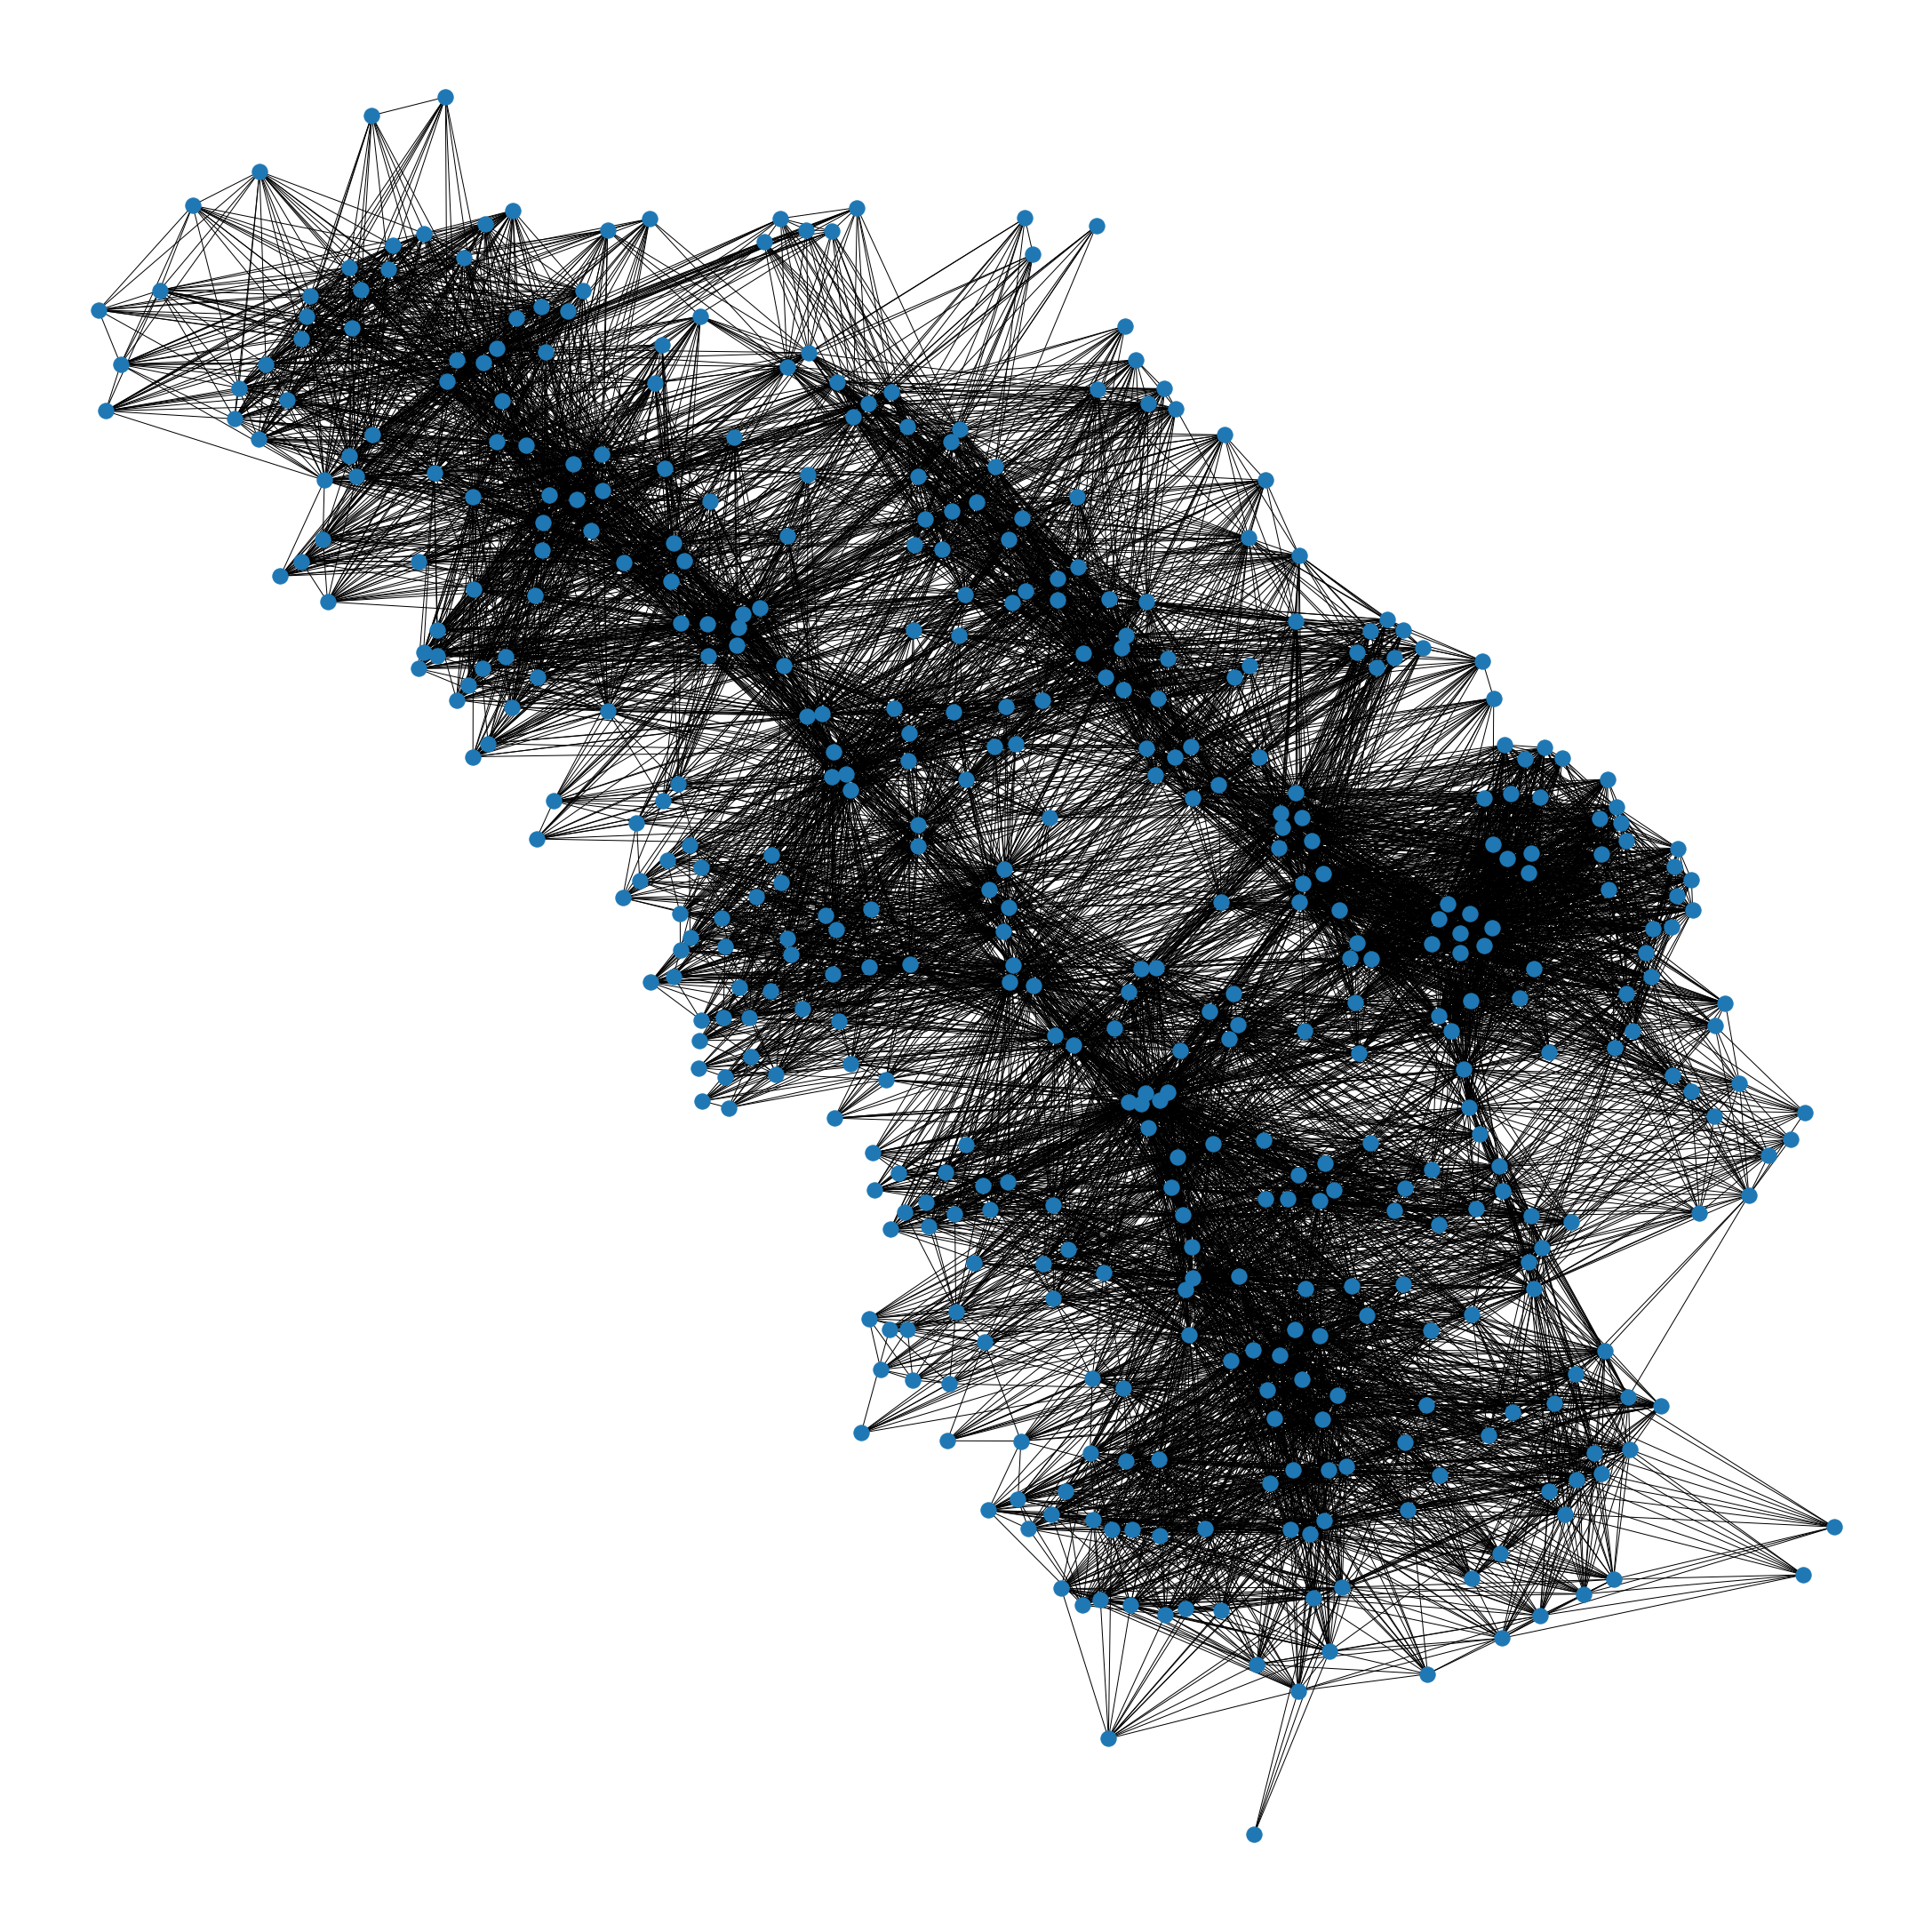

In [19]:
G = nx.Graph()
G.add_nodes_from(index_2017.index)

for tile, row in index_2017.iterrows():
    for overlap_tile in row['overlap']:
        G.add_edge(tile, overlap_tile)
plt.figure(figsize=(30,30))
nx.draw_kamada_kawai(G, with_labels=False)


There are a lot of overlap chains, meaning that we may have to manually decide where to split these mosaics.

### Function to Open Raster from Server, Mask, and check it

In [14]:
def mask_from_server(raster):
    url = raster['fileurl']
    rio_url = 'tar+' + url + '!' + raster.name + '_dem.tif'  # format url for remote access
    src = rio.open(rio_url)
    
    print(src.shape)
    xmin, xmax = raster['minx'], raster['maxx']
    ymin, ymax = raster['miny'], raster['maxy']
        
    bbox = shapely.geometry.box(raster['minx'], raster['miny'], raster['maxx'], raster['maxy'])  # create bounding box for area of interest
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=src.crs)
    geo = [json.loads(geo.to_json())['features'][0]['geometry']]
    out_img, out_transform = mask(src, shapes=geo, crop=True)  # Mask the raster

#     window = rio.windows.from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
    
    out_meta = src.meta.copy()
    out_meta.update({'driver':'GTiff',
                     'height': out_img.shape[1],
                     'width': out_img.shape[2],
                     'transform': src.transform,
                     'crs': src.crs
                    })
    
    with rio.open('../data/rasters/' + raster.name + '.tif', 'w', **out_meta) as dst:
        dst.write(out_img, 1)


In [ ]:
mask_from_server(index_2017.loc[index_2017.iloc[0]['overlap'][34]])

(24962, 56104)


### Looking at Pingo Sites

#### DEM
<img src="https://i.imgur.com/2MpRVdZ.png">

#### Slope
<img src="https://i.imgur.com/jh4U3hB.png">


#### Aspect
<img src="https://i.imgur.com/hkYr8IA.png">




### Calculate Difference in Overlapping Rasters

Two overlapping rasters were loaded into QGIS and their difference calculated using the Raster Calculator.

We will calculate the mean difference using this raster.

In [17]:
with rio.open('../data/rasters/overlap_diff.tif') as src:
    data = src.read(1)
    mask = src.read_masks(1)
    diff = data * mask / 255
    print('Mean Difference:', diff.mean())
    print('Max Difference:', diff.max())
    print('Min Difference:', diff.min())

Mean Difference: -0.40636072
Max Difference: 40.741398
Min Difference: -30.982344


### Download Data

**Note that the data can be opened remotely, without downloading. See the cells below.**

The files are stored remotely in .tar.gz format, they must be downloaded first before they can be opened and GeoTIFF data extracted.

In [ ]:
def download_file(row):
    fileurl = row['fileurl']
    name = row['name']
    
    file_dir = os.path.join('../data/rasters/', name)
    if not os.path.exists(file_dir):
        wget.download(fileurl, file_dir)
    

In [ ]:
download_file(index_2017.iloc[1])

In [ ]:
url = index_2017.iloc[0]['fileurl']
data = index_2017.iloc[0]
print(data)

src = rio.open('../data/rasters/SETSM_GE01_20120812_10504100007A7300_1050410000751500_seg1_2m_v3/SETSM_GE01_20120812_10504100007A7300_1050410000751500_seg1_2m_v3.0_dem.tif')
bbox = rio.coords.BoundingBox(data['minx'], data['miny'], data['maxx'], data['maxy'])
# show(src)
print('Raster:', src.bounds)
print('CSV:', bbox)